This notebook will show an example use case for MedianDecompose and AnomalyDetection on the decomposed time series. The sample data are included in the repository, please try it out. Contributions welcome!

# MedianDecompose Example

In this example, the sample dataset are a series of vehicle travel times during September 2022 along different segments of Sunnyside Road in Happy Valley, Oregon. The location was chosen due to its cheerful name and because unusual delays were caused by paving projects during the analyzed time period.

In [1]:
from MedianDecompose import MedianDecompose
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('sample_data.csv', parse_dates=['TimeStamp']).astype({'XD':'uint32'})
df.head(3)

,XD,TimeStamp,travel_time_seconds
0,448838574,2022-09-02 06:00:00,20.7100
1,448838574,2022-09-02 07:00:00,22.9525
2,448838574,2022-09-02 08:00:00,23.5575


The 'XD' column is the identifier for the different roadway segments. MedianDecompose works on multiple time series at once!

In [2]:
model = MedianDecompose(df, freq_minutes=60, min_periods=56, DateTime_Name='TimeStamp',
                        ID_Name='XD', Value_Name='travel_time_seconds')
decomp = model.fit()
decomp.head(3)

Frequency set at 60min


,,travel_time_seconds,RollingMedian,SeasonDay,SeasonWeek,Resid,SeasonAdjusted
TimeStamp,XD,,,,,,
2022-09-13 06:00:00,448838574,25.607500,24.889999,-4.177499,1.510,3.385,28.275000
2022-09-13 07:00:00,448838574,23.965000,24.889999,-1.155000,0.230,0.000,24.889999
2022-09-13 08:00:00,448838574,23.772499,24.889999,-0.952500,-0.165,0.000,24.889999


Now that the travel times time series has been decomposed, look at a sample time period for just one roadway segment and plot it.

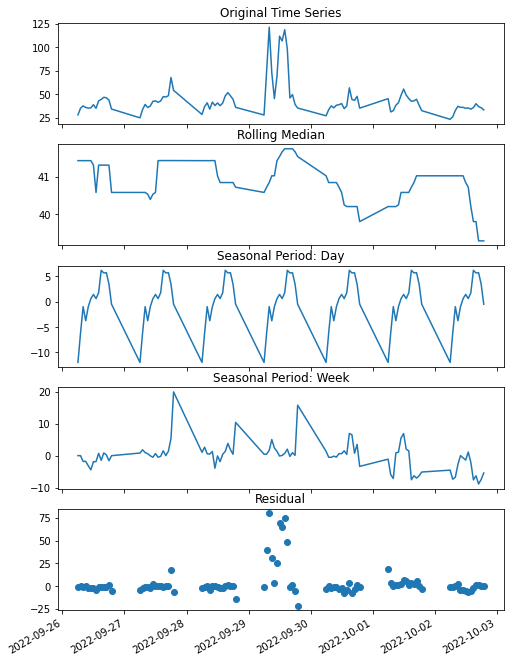

In [3]:
sample = decomp.sort_index().loc(axis=0)['2022-09-26':'2022-10-02',[448905975]]
x = sample.index.get_level_values(level=0)

plt.rcParams["figure.figsize"] = (8,12)
fig, ax = plt.subplots(5)
ax[0].plot_date(x, sample['travel_time_seconds'].values, marker='', linestyle='-')
ax[0].set_title('Original Time Series')
ax[1].plot_date(x, sample['RollingMedian'].values, marker='', linestyle='-')
ax[1].set_title('Rolling Median')
ax[2].plot_date(x, sample['SeasonDay'].values, marker='', linestyle='-')
ax[2].set_title('Seasonal Period: Day')
ax[3].plot_date(x, sample['SeasonWeek'].values, marker='', linestyle='-')
ax[3].set_title('Seasonal Period: Week')
ax[4].plot_date(x, sample['Resid'].values)
ax[4].set_title('Residual')
fig.autofmt_xdate()
plt.show()

As you can see, there are severe outliers occuring on the 29th, but they do not show up in the seasonal periods, they only show up in the residuals. For further analysis, the residual components can be normalized and outliers classified using thresholds on the entire dataset. This enables automated outlier detection for multiple time series at once!

# AnomalyDetection Example

(continued from above)

In [4]:
from AnomalyDetection import Anomaly

result = Anomaly(decomp, DateTime_Name='TimeStamp', ID_Name='XD', Value_Name='Resid', z_score=3.0).find_anomalies()
result.head(3)

,,travel_time_seconds,RollingMedian,SeasonDay,SeasonWeek,Resid,SeasonAdjusted,Anomaly
TimeStamp,XD,,,,,,,
2022-09-13 06:00:00,448838574,25.607500,24.889999,-4.177499,1.510,3.385,28.275000,False
2022-09-13 07:00:00,448838574,23.965000,24.889999,-1.155000,0.230,0.000,24.889999,False
2022-09-13 08:00:00,448838574,23.772499,24.889999,-0.952500,-0.165,0.000,24.889999,False


Now, display the anomalies found as red dots overlaid onto the plot made in the previous step.

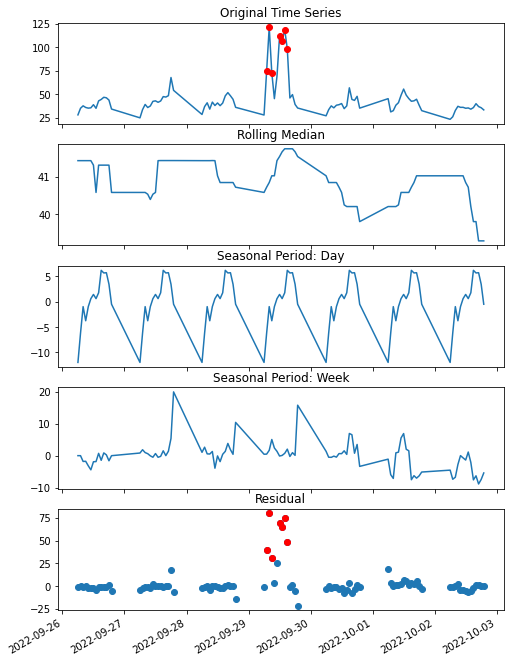

In [5]:
anomaly_sample = result.sort_index().loc(axis=0)['2022-09-26':'2022-10-02',[448905975]]
anomaly_sample = anomaly_sample[anomaly_sample['Anomaly']]
anomaly_x = anomaly_sample.index.get_level_values(level=0)

ax[0].plot_date(anomaly_x, anomaly_sample['travel_time_seconds'].values, color='red')
ax[4].plot_date(anomaly_x, anomaly_sample['Resid'].values, color='red')
fig

### Using the Group_Name parameter
Below, the group "District" is joined to the data. This small smaple dataset includes only a single highway, so there is only 1 group. The paving operations that occured impacted the entire group, so when we add the group parameter, it turns out none of the travel times for any of the individual roadway segments was significantly different from the rest, so there are actually no anomalies and our table is empty.

In [6]:
groups = pd.read_csv('sample_data_groups.csv', index_col='XD')
grouped_data = decomp.join(groups)
result = Anomaly(grouped_data, DateTime_Name='TimeStamp', ID_Name='XD', Value_Name='Resid', z_score=3.0, Group_Name='District').find_anomalies()
result[result['Anomaly']]

,,travel_time_seconds,RollingMedian,SeasonDay,SeasonWeek,Resid,SeasonAdjusted,Anomaly,District,RoadName
TimeStamp,XD,,,,,,,,,
